# Notes

The q-shifting is related to update_f_pop_cross. 
update_q got no problem by holding the rest.
update_f_pop got no problem by holding the rest.
While there's a problem by fitting them together. 
Time-warp spike trains backward is not quite equivalent to the time-warp the lambda.

In [401]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:70% !important; }</style>"))
import numpy as np; np.set_printoptions(linewidth=110);
import pandas as pd
pd.set_option("display.max_columns", None)

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import matplotlib.pyplot as plt
import scipy
import seaborn
from tqdm import tqdm
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

import data_visualizer
import data_model
import hierarchical_sampling_model
import util
import smoothing_spline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
import allensdk
import h5py
import pynwb
import pandas
import hdmf
print('allensdk', allensdk.__version__)
print('h5py', h5py.__version__)
print('pynwb', pynwb.__version__)
print('pandas', pandas.__version__)
print('hdmf', hdmf.__version__)

allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
pandas 1.1.1
hdmf 2.2.0


In [3]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

Download time: 720000


In [6]:
session_id = 798911424  #  791319847 798911424  799864342
session = cache.get_session_data(session_id)

# Load data

### Neurons Selection

In [7]:
probes = ['probeC', 'probeD', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) &
    session.units['probe_description'].isin(probes)]
display(selected_units['probe_description'].value_counts())
display(selected_units['probe_description'].count())

probeC    94
probeE    89
probeD    78
Name: probe_description, dtype: int64

261

## Trials Selection

In [427]:
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
display(stimulus_table)

,contrast,orientation,phase,size,spatial_frequency,start_time,stimulus_block,stimulus_name,stop_time,temporal_frequency,duration,stimulus_condition_id
stimulus_presentation_id,,,,,,,,,,,,
3798,0.8,0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1586.180717,2,drifting_gratings,1588.182387,15,2.00167,246
3799,0.8,180,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1589.183244,2,drifting_gratings,1591.184924,2,2.00168,247
3800,0.8,45,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1592.185737,2,drifting_gratings,1594.187427,1,2.00169,248
3801,0.8,90,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1595.188274,2,drifting_gratings,1597.189944,8,2.00167,249
3802,0.8,270,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,1598.190777,2,drifting_gratings,1600.192447,2,2.00167,250
...,...,...,...,...,...,...,...,...,...,...,...,...
49428,0.8,315,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,5384.355314,7,drifting_gratings,5386.356974,4,2.00166,260
49429,0.8,0,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,5387.357797,7,drifting_gratings,5389.359487,1,2.00169,252
49430,0.8,90,"[5308.98333333, 5308.98333333]","[250.0, 250.0]",0.04,5390.360334,7,drifting_gratings,5392.361994,8,2.00166,249


#### drifting gratings

In [118]:
# condition_ids = [268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x12 7989
# condition_ids = [275, 268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x13 7989

In [625]:
condition_ids = [275, 268, 270, 284, 274, 249, 261, 278, 280, 256, 260, 257, 281]  # x13 7989
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_df = stimulus_table[stimulus_table['stimulus_condition_id'].isin(condition_ids)]
all_trials_indices = trials_df.index.values
trials_groups = trials_df.groupby('stimulus_condition_id')
all_condition_ids = list(trials_groups.groups.keys())
hierarchical_sampling_model.HierarchicalSamplingModel.print_conditions(trials_groups)

0  249 temp freq [8.0] orient [90.0] contrast [0.8] [ 3801  3810  3828  3911  3964 31002 31054 31055 31178 49257 49317 49341 49365 49395 49430]
1  256 temp freq [15.0] orient [270.0] contrast [0.8] [ 3811  3845  3942  3958 31003 31056 31112 31126 31137 31169 31191 49260 49305 49344 49381]
2  257 temp freq [8.0] orient [315.0] contrast [0.8] [ 3813  3822  3870  3876  3932  3936  3987 31022 31027 31075 31171 49215 49217 49368 49370]
3  260 temp freq [4.0] orient [315.0] contrast [0.8] [ 3816  3888  3930  3943  3948 31028 31033 31190 49263 49266 49320 49364 49410 49411 49428]
4  261 temp freq [8.0] orient [135.0] contrast [0.8] [ 3817  3826  3875  3928 31020 31053 31129 31161 31162 49230 49254 49268 49275 49313 49407]
5  268 temp freq [4.0] orient [45.0] contrast [0.8] [ 3833  3882  3884  3899  3951  3988 31040 31086 31089 31116 31149 31197 49255 49277 49327]
6  270 temp freq [8.0] orient [45.0] contrast [0.8] [ 3835  3898  3914  3934 31062 31104 31114 49250 49274 49281 49286 49304 49322 

## Spike Trains

In [626]:
data_loader = data_model.AllenInstituteDataModel(session)
trial_time_window=[0.0, 0.5]
dt=0.002
spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)
spike_trains = data_loader.get_trial_metric_per_unit_per_trial(
    stimulus_presentation_ids=all_trials_indices,
    unit_ids=selected_units.index.values,
    trial_time_window=trial_time_window,
    metric_type='spike_trains', dt=dt)
spike_times = data_loader.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=all_trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_time_window,
        metric_type='spike_times')

In [627]:
display(spike_trains.shape)
# display(spike_trains.head())
display(spike_times.shape)
# display(spike_times.head())

(261, 195)

(261, 195)

# Initialization

In [669]:
np.random.seed(0)
model = hierarchical_sampling_model.HierarchicalSamplingModel(session)
model.initial_step(spike_trains, spike_times, spike_train_time_line, selected_units, trials_groups,
                   trial_time_window, probes=['probeC', 'probeD', 'probeE'], num_areas=3, num_groups=3,
                   model_feature_type='BSS', prior_type='diag', eta_smooth_tuning=3e-8, verbose=False)
experiment_folder = f'{session_id}_BSS_MC_0_500ms_probeCDE_condition{len(condition_ids)}_' + \
                    f'diag_prior_alpha5_no_q_prop_{time.strftime("%Y%m%d_%H%M%S")}'
batches_dir = f'D:/Brain_Network/Output/models/'

Model feature type:  BSS
Condition: 0  stimulus_condition_id:249
probeC g:[2 1 0] counts:[38 32 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[36 31 22]  
Condition: 1  stimulus_condition_id:256
probeC g:[2 1 0] counts:[39 32 23]  probeD g:[2 1 0] counts:[33 25 20]  probeE g:[2 1 0] counts:[36 31 22]  
Condition: 2  stimulus_condition_id:257
probeC g:[2 1 0] counts:[39 33 22]  probeD g:[2 1 0] counts:[34 24 20]  probeE g:[2 1 0] counts:[37 30 22]  
Condition: 3  stimulus_condition_id:260
probeC g:[2 1 0] counts:[39 32 23]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[37 30 22]  
Condition: 4  stimulus_condition_id:261
probeC g:[2 1 0] counts:[39 32 23]  probeD g:[2 1 0] counts:[32 26 20]  probeE g:[2 1 0] counts:[37 30 22]  
Condition: 5  stimulus_condition_id:268
probeC g:[2 1 0] counts:[40 30 24]  probeD g:[2 1 0] counts:[31 27 20]  probeE g:[2 1 0] counts:[37 30 22]  
Condition: 6  stimulus_condition_id:270
probeC g:[2 1 0] counts:[39 31 24]  probe

In [670]:
clist = list(range(len(condition_ids)))

trange = tqdm(range(0, 6000), ncols=100, file=sys.stdout)
for itr in trange:
    for c in clist:
        if itr < 40:
            model.update_f_local_pop_cag(c, sample_type='fit', verbose=False)
            model.update_f_cross_pop_ca_2(c, sample_type='fit', record=(c==clist[-1]), verbose=False)
        elif itr >= 40:
            model.update_f_local_pop_cag(c, sample_type='sample', verbose=False)
            model.update_f_cross_pop_ca_2(c, sample_type='sample', record=(c==clist[-1]), verbose=False)

        if itr < 15:
            model.update_q_arc(c, sample_type='fit', fit_peak_ratio=0,
                               record=(c==clist[-1]), verbose=False)
        elif (itr >= 15) and (itr < 40):  # Fit with peak.
            model.update_q_arc(c, sample_type='fit', fit_peak_ratio=0.05, 
                               record=(c==clist[-1]), verbose=False)
        elif (itr >= 40):
            model.update_q_arc(c, sample_type='sample', proposal_scalar=0.03, 
                               fit_peak_ratio=max(0, 0.01-0.01/1000*itr), record=(c==clist[-1]), verbose=False)

        if itr >= 20:
            model.update_z_ngac(c, sample_type='sample', 
                                record=(c==clist[-1]), verbose=False)
            model.update_p_gac(c, sample_type='sample', 
                               record=(c==clist[-1]), verbose=False)
    if itr > 50:
        model.update_mu_simga(clist=clist, sample_type='iw_sample', verbose=False)

    model.complete_log_likelihood(clist)
    trange.set_description(f'{model.samples.log_likelihood[-1]:.1f} |q {model.samples.q_accept_ratio_mean:.3f} '+
                           f'|f {model.samples.f_cross_pop_accept_ratio:.3f}')
    model.recorder(itr, batches_dir, experiment_folder, force_save=False, batch_size=500)


-558885.0 |q 0.000 |f 0.000:   0%|                             | 24/6000 [10:14<49:42:09, 29.94s/it]Warning: Reaches maximum number of iterations.
-558224.4 |q 0.174 |f 0.051:   1%|▏                            | 41/6000 [17:55<36:33:20, 22.08s/it]Warning: Drawing q_cnd samples runs out of iterations c=3 r=2
-558268.3 |q 0.195 |f 0.051:   1%|▏                            | 42/6000 [18:05<30:20:36, 18.33s/it]Warning: Drawing q_cnd samples runs out of iterations c=3 r=2
-558546.3 |q 0.220 |f 0.070:   1%|▏                            | 51/6000 [19:29<16:01:21,  9.70s/it]Warning: Drawing q_cnd samples runs out of iterations c=3 r=2
-558075.5 |q 0.255 |f 0.085:   1%|▎                            | 58/6000 [20:35<15:26:17,  9.35s/it]Warning: Drawing q_cnd samples runs out of iterations c=3 r=2
-558185.8 |q 0.299 |f 0.094:   1%|▎                            | 71/6000 [22:34<15:06:59,  9.18s/it]Warning: Drawing q_cnd samples runs out of iterations c=3 r=3
-558154.6 |q 0.300 |f 0.095:   1%|▎        

## Load samples batches

In [671]:
model.samples.peek()

f_pop:0  f_pop_beta:0  q:0  q_shift1:0  q_shift2:0  f_warp_sources:0  f_warp_targets:0  mu_cross_pop:0  sigma_cross_pop:0  rho_cross_pop_simple:0  z:0  p:0  log_likelihood:0  


In [672]:
model = hierarchical_sampling_model.HierarchicalSamplingModel(session, empty_samples=True)
model_dir = project_dir + 'Output/models/'

load_dir = model_dir + '798911424_BSS_MC_0_500ms_probeCDE_condition13_diag_prior_alpha5_no_q_prop_20211102_091017/'
model_file = load_dir + '798911424_checkpoints_batch0_20211102_104151.pkl'
model.load_model(model_file)
model_file = load_dir + '798911424_checkpoints_batch11_20211103_012324.pkl'
model.load_model(model_file)

In [673]:
model.samples.load_batches(load_dir, start_id=0, end_id=15, thin_step=1)

Find 12 batches.
D:/Brain_Network/Output/models/798911424_BSS_MC_0_500ms_probeCDE_condition13_diag_prior_alpha5_no_q_prop_20211102_091017\798911424_samples_batch0_20211102_104151.pkl
D:/Brain_Network/Output/models/798911424_BSS_MC_0_500ms_probeCDE_condition13_diag_prior_alpha5_no_q_prop_20211102_091017\798911424_samples_batch1_20211102_120309.pkl
D:/Brain_Network/Output/models/798911424_BSS_MC_0_500ms_probeCDE_condition13_diag_prior_alpha5_no_q_prop_20211102_091017\798911424_samples_batch2_20211102_132606.pkl
D:/Brain_Network/Output/models/798911424_BSS_MC_0_500ms_probeCDE_condition13_diag_prior_alpha5_no_q_prop_20211102_091017\798911424_samples_batch3_20211102_144424.pkl
D:/Brain_Network/Output/models/798911424_BSS_MC_0_500ms_probeCDE_condition13_diag_prior_alpha5_no_q_prop_20211102_091017\798911424_samples_batch4_20211102_160549.pkl
D:/Brain_Network/Output/models/798911424_BSS_MC_0_500ms_probeCDE_condition13_diag_prior_alpha5_no_q_prop_20211102_091017\798911424_samples_batch5_2021110

In [462]:
# model.samples.clear_samples_memory()

## Plot results

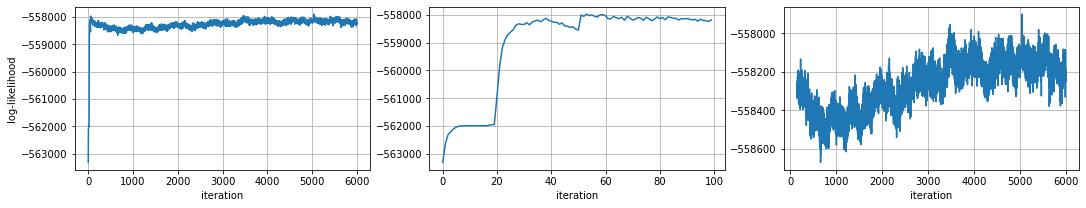

In [674]:
model.samples.plot_log_likelihood()

## f_pop

f_samples.shape: (60, 13, 3, 3, 250)
accept ratio: 0.27584753054551714 64118 232440


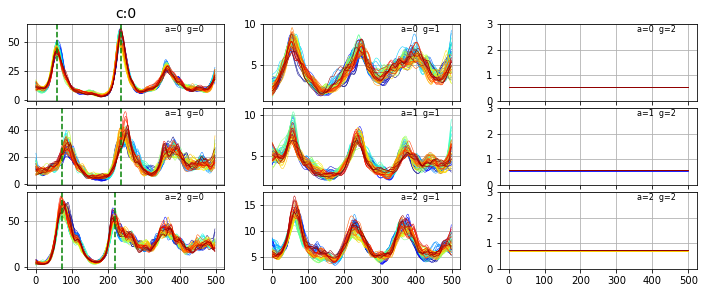

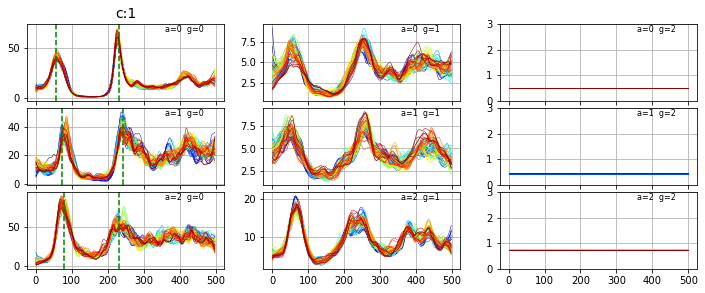

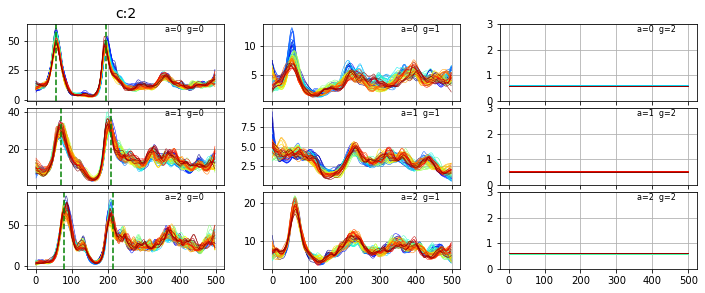

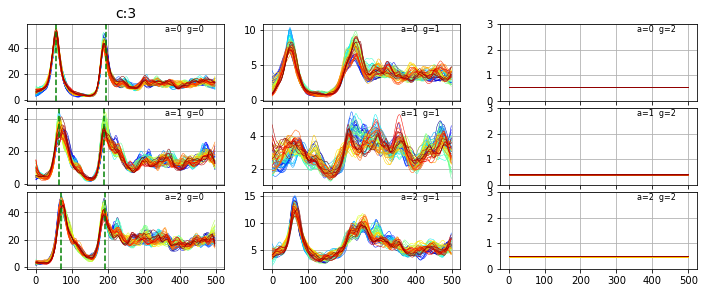

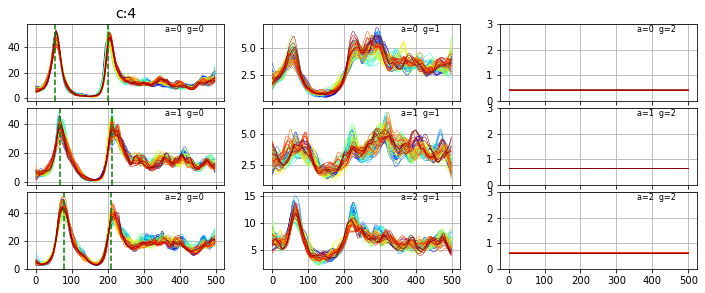

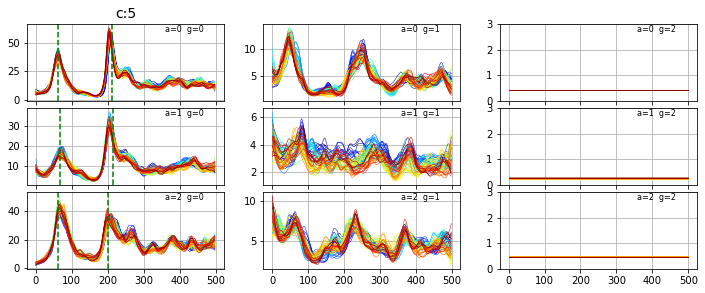

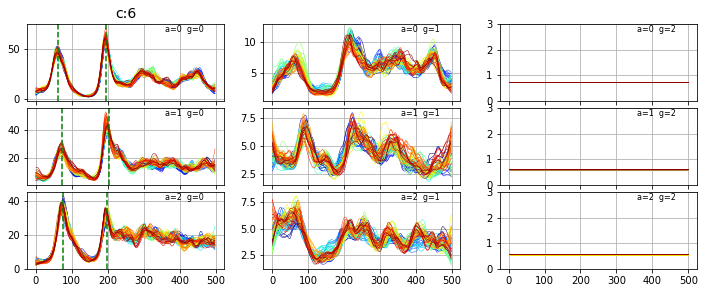

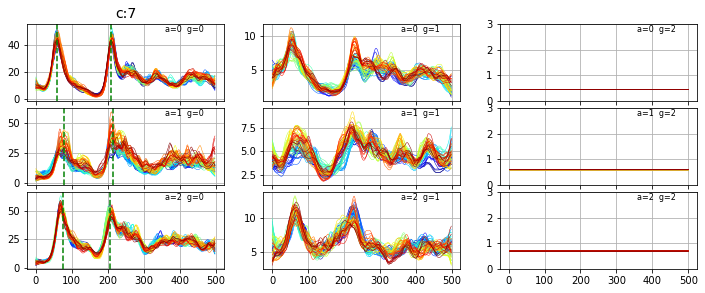

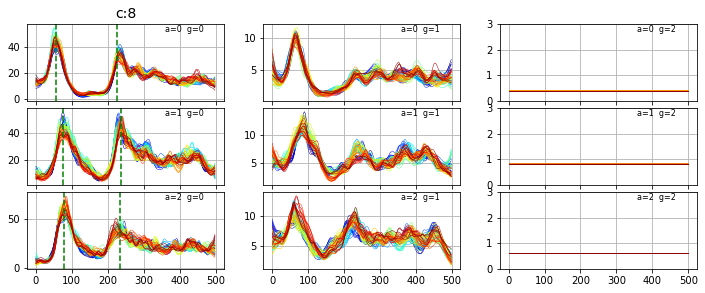

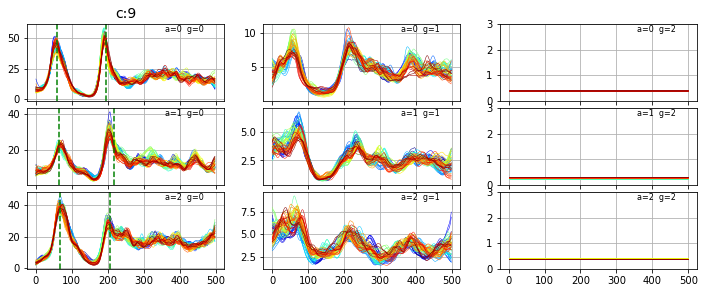

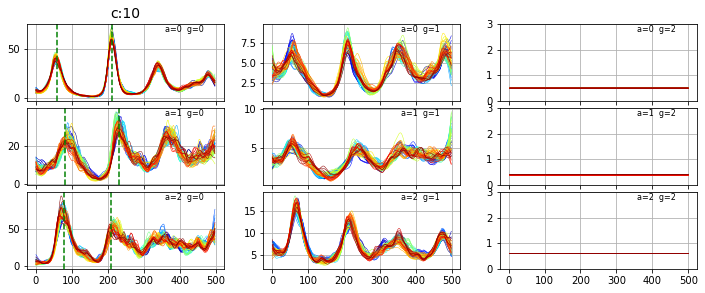

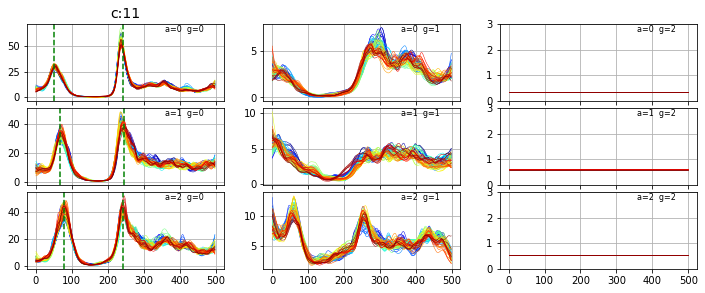

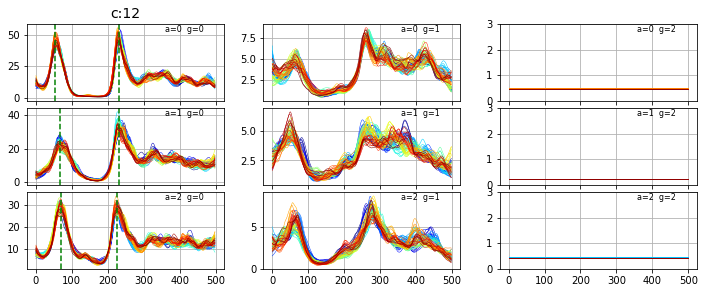

In [675]:
clist = list(range(len(condition_ids)))
model.samples.plot_f_pop_rainbow(clist, spike_train_time_line, burn_in=3000, end=None, step=50,
                                 f_peak1_ac_ref=model.f_peak1_ac, f_peak2_ac_ref=model.f_peak2_ac)

Note that the baseline is fitted during update_f_pop 'fit', when it moves to 'sample' phase, the baseline is almost held as fixed for stability concern.

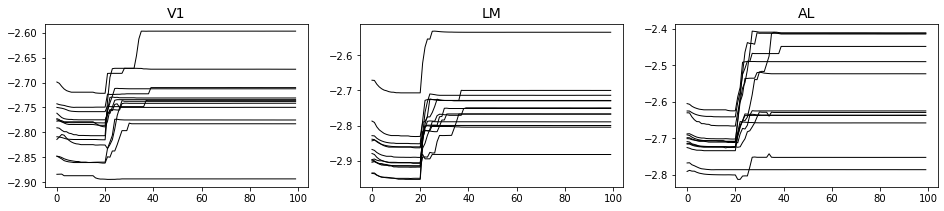

In [677]:
model.samples.plot_f_pop_baseline(clist, burn_in=0,end=100,step=1)

### $q_{a,r,c}$ features

In [397]:
output_dir = 'D:/Brain_Network/Output/fig/'
clist = list(range(len(condition_ids)))
q_arc_naive = model.naive_q_arc(verbose=0)
# f_peak1, _ = model.naive_peak_shift_arc(
#     clist=clist, option='q_shift1', fit_type='model', kernel_par=3,
#     verbose=1, output_dir=None)
# f_peak2, _ = model.naive_peak_shift_arc(
#     clist=clist, option='q_shift2', fit_type='model', kernel_par=5,
#     verbose=1, output_dir=None)

probeC-probeD gain corr:0.718  p:3.179e-32
probeC-probeE gain corr:0.491  p:3.364e-13
probeD-probeE gain corr:0.762  p:2.843e-38


Estimated corr:0.836  p-value:3.141e-52
Accept ratio: 0.3627103768714507 min: 0.022818791946308724 max: 0.5763422818791947
num_qs: 15
q_samples.shape:  (6000, 3, 15, 13)
sub q shape: (4, 6000, 15)
Area 0
mean [ 1.22366637e-02  2.04250450e-06 -2.25109680e-03 -7.48856211e-03]
std  [0.18968013 0.16728127 0.19687801 0.19566371]
mean/std [ 6.45121003e-02  1.22100011e-05 -1.14339675e-02 -3.82726167e-02]


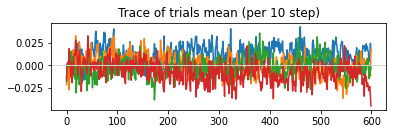

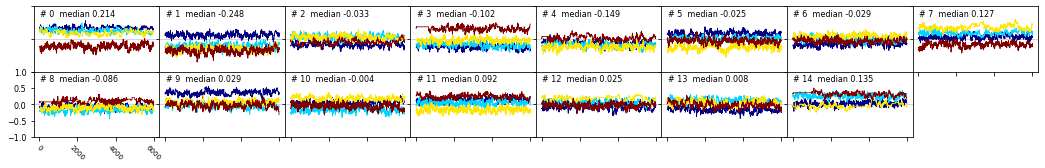

sub q shape: (4, 6000, 15)
Area 1
mean [ 0.02925047  0.00405461 -0.00542777 -0.02362362]
std  [0.41086363 0.28810538 0.33313667 0.25385211]
mean/std [ 0.07119264  0.01407337 -0.01629292 -0.09306055]


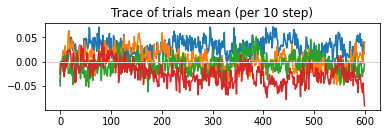

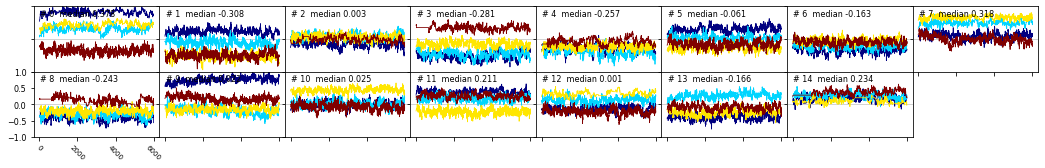

sub q shape: (4, 6000, 15)
Area 2
mean [ 0.01878705  0.00286734 -0.00346749 -0.01591538]
std  [0.41966111 0.28676701 0.27319826 0.20587234]
mean/std [ 0.04476719  0.00999883 -0.01269222 -0.07730704]


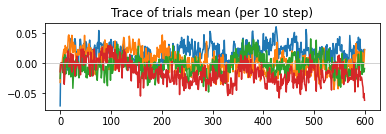

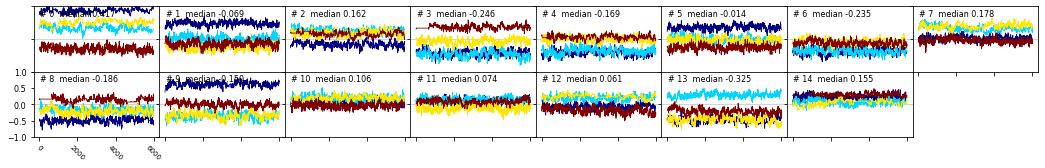

In [678]:
clist = [0,1,2,3]
model.samples.plot_q_arc(clist, burn_in=0, end=None, step=1, option='q', q_arc_ref=None, ylim=[-1, 1])
# model.samples.plot_q_arc(clist, burn_in=0, end=None, step=1, option='q_shift1', ylim=[-0.05, 0.05])


Estimated corr:0.920  p-value:3.058e-80
Accept ratio: 0.3627103768714507 min: 0.022818791946308724 max: 0.5763422818791947
num_qs: 15
q_samples.shape:  (6000, 3, 15, 13)
sub q shape: (4, 6000, 15)
Area 0
mean [-0.00320576 -0.00060905  0.00065562  0.00255297]
std  [0.02947139 0.03518937 0.02948168 0.02827456]
mean/std [-0.10877529 -0.01730768  0.02223825  0.0902922 ]


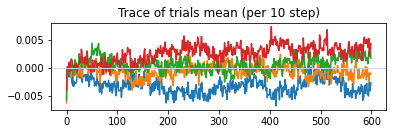

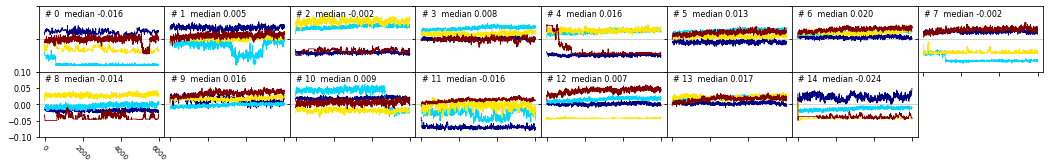

sub q shape: (4, 6000, 15)
Area 1
mean [-0.00365066 -0.00061325  0.00067604  0.00314582]
std  [0.02937016 0.03529166 0.03900053 0.03010052]
mean/std [-0.1242984  -0.01737673  0.01733401  0.10451039]


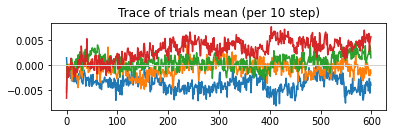

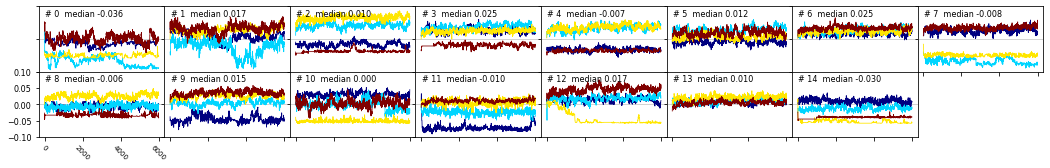

sub q shape: (4, 6000, 15)
Area 2
mean [-0.00358162 -0.0006199   0.00057179  0.00291044]
std  [0.03434381 0.03634813 0.04105481 0.03359938]
mean/std [-0.10428728 -0.01705453  0.01392747  0.08662185]


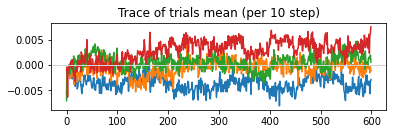

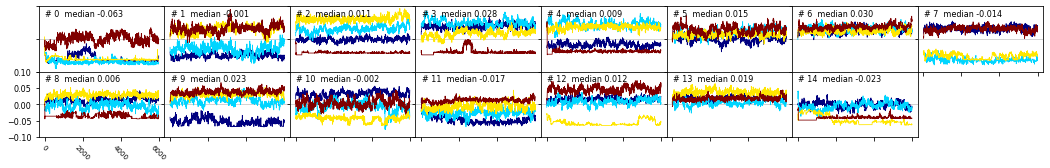

In [679]:
model.samples.plot_q_arc(clist, burn_in=0, end=None, step=1, option='q_shift2', ylim=[-0.1, 0.1])

Save figure to:  D:/Brain_Network/Output/fig/798911424_t3855_trial_demo.pdf


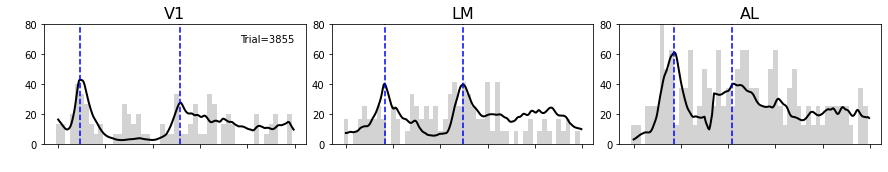

In [535]:
output_dir = f'D:/Brain_Network/Output/fig/'
model.plot_group_activity_per_trial_demo(c=2, r=0, show_label=False, output_dir=output_dir)

sources.shape: (30, 3, 15, 13, 6)
targets.shape: (30, 3, 15, 13, 6)
f_pop.shape: (30, 13, 3, 3, 250)
peak1_a.shape (3, 30)
CI_left 153.71, CI_right 157.39, mode 155.96
CI_left 143.57, CI_right 150.70, mode 148.06
CI_left 139.06, CI_right 144.17, mode 140.29
save figure: D:/Brain_Network/Output/fig/798911424_lead_lag_peak2_peak1.pdf


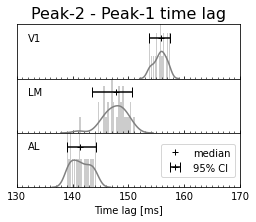

CI_left 12.84, CI_right 18.42, mode 15.94
CI_left 14.44, CI_right 19.54, mode 16.71
CI_left -4.45, CI_right 2.79, mode -0.36
save figure: D:/Brain_Network/Output/fig/798911424_lead_lag_peak1.pdf


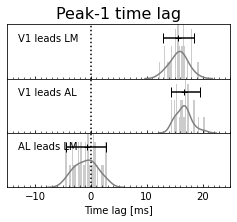

CI_left 5.32, CI_right 9.55, mode 7.90
CI_left 0.07, CI_right 5.53, mode 1.76
CI_left 2.28, CI_right 8.60, mode 4.43
save figure: D:/Brain_Network/Output/fig/798911424_lead_lag_peak2.pdf


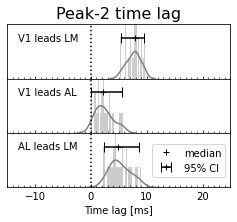

CI_left 11.38, CI_right 14.66, mode 12.84
CI_left 12.14, CI_right 14.45, mode 13.33
CI_left -2.21, CI_right 1.60, mode -0.09
save figure: D:/Brain_Network/Output/fig/798911424_lead_lag_initiation.pdf


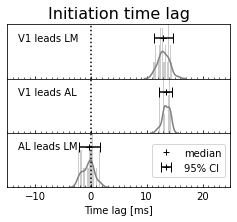

CI_left 4.49, CI_right 11.81, mode 8.08
CI_left 9.69, CI_right 17.22, mode 15.26
CI_left 0.13, CI_right 11.04, mode 6.79
save figure: D:/Brain_Network/Output/fig/798911424_lead_lag_XP2_YP2_XP1_YP1.pdf


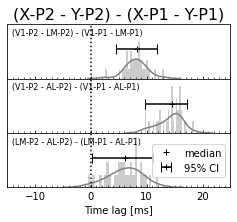

In [680]:
output_dir = f'D:/Brain_Network/Output/fig/'
clist = list(range(len(condition_ids)))
model.samples.plot_lead_lag_CI(clist, spike_train_time_line, fit_type='refine',
                               burn_in=3000, end=None, step=100, verbose=False, output_dir=output_dir)

### $\Sigma$ features correlation

sigma_samples.shape: (5949, 9, 9)
rho_samples.shape: (5949, 9, 9)


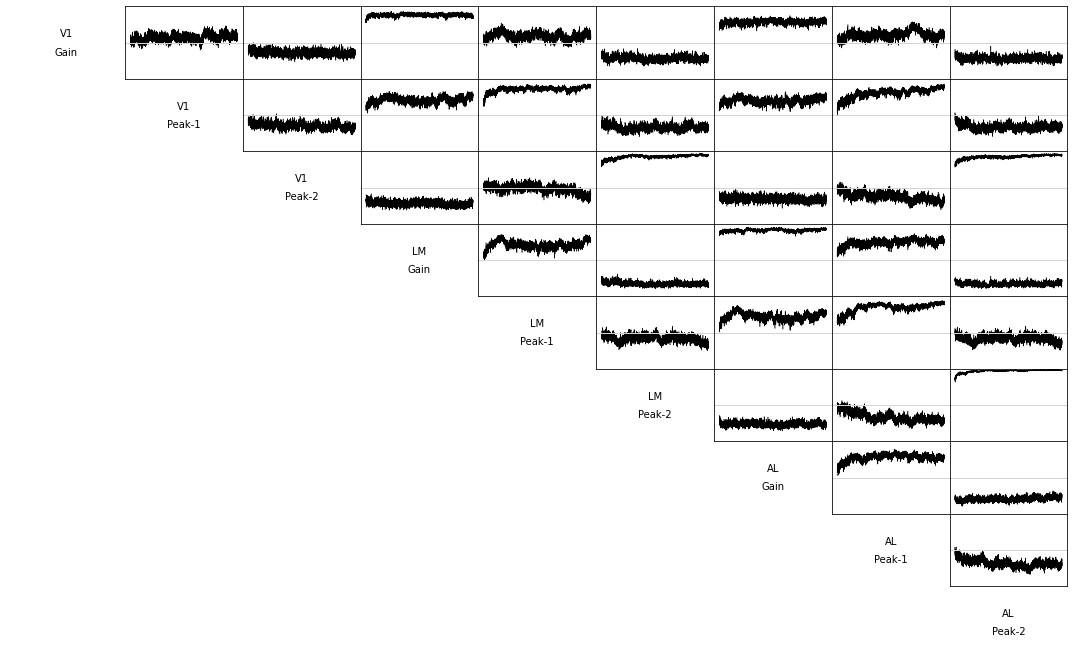

In [668]:
partial_adj = model.samples.plot_correlation_traces(rho_type='marginal')

sigma_samples.shape: (1449, 9, 9)


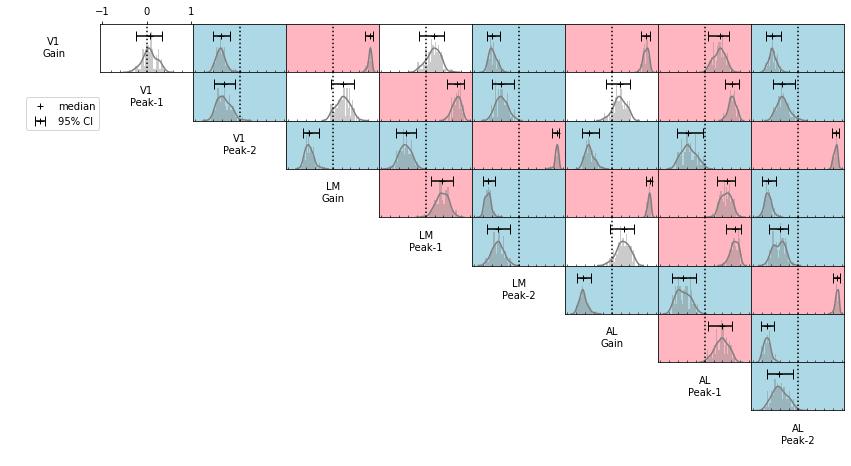

In [605]:
output_dir = 'D:/Brain_Network/Output/fig/'
marginal_adj, marginal_adj2, marginal_pval_adj = model.samples.plot_marginal_correlation(
    0, 1, burn_in=500, end=None, step=10, plot_type='rho', distribution_type='CI_hist', output_dir=None)

sigma_samples.shape: (5949, 9, 9)
rho_samples.shape: (5949, 9, 9)


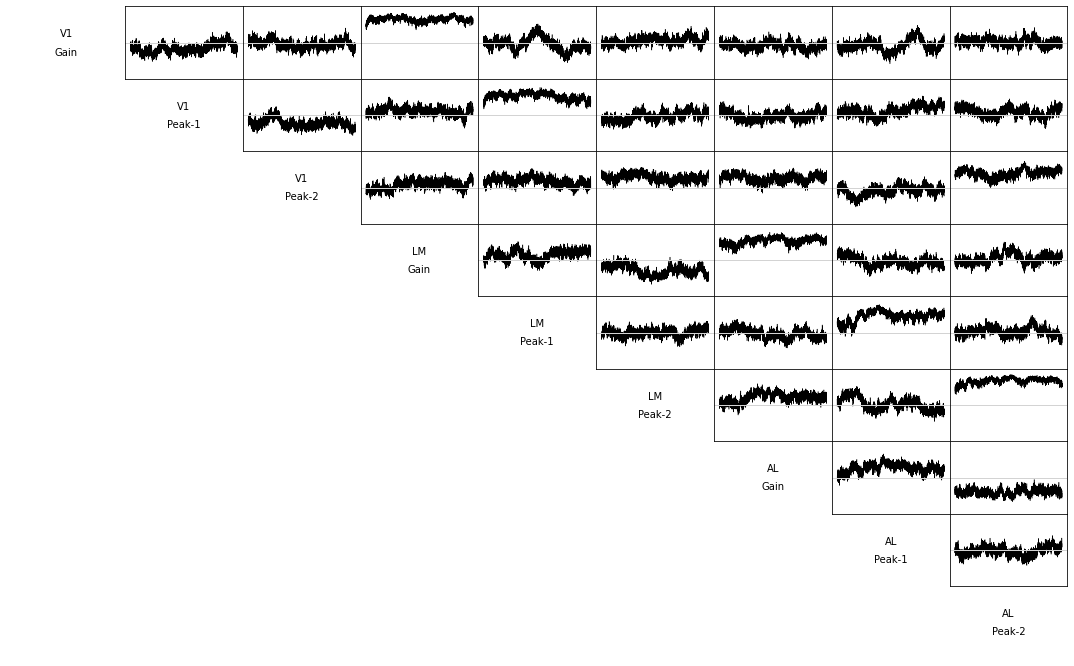

In [667]:
model.samples.plot_correlation_traces(rho_type='partial')

sigma_samples.shape: (5949, 9, 9)
rho_samples.shape: (295, 9, 9)


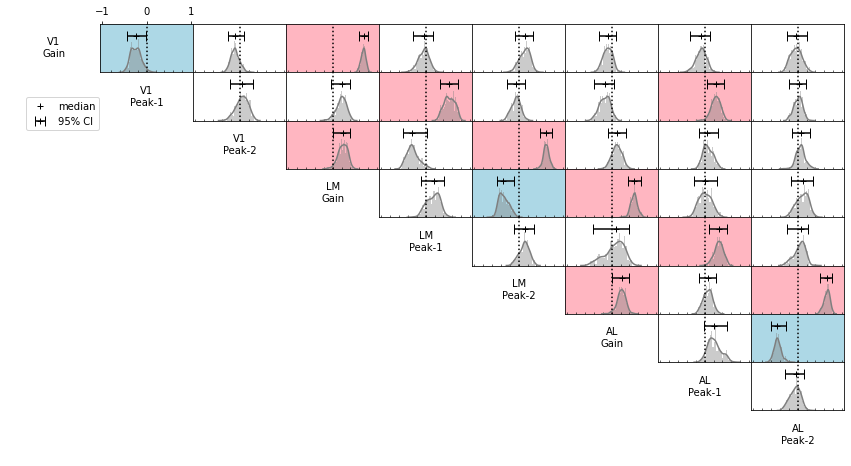

In [681]:
output_dir = 'D:/Brain_Network/Output/fig/'
partial_adj, partial_adj2, pval_mat = model.samples.plot_partial_correlation(0,1, burn_in=3000, end=None, step=10,
    distribution_type='CI_hist', output_dir=None)

sigma_samples.shape: (5949, 3, 3)
rho_samples.shape: (5749, 3, 3)
CI_left -0.25, CI_right 0.22, mode -0.09
Save figure to:  D:/Brain_Network/Output/fig/V1_P2_AL_P2_Z_LM_P2_conditional_corr_embedded.pdf


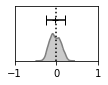

sigma_samples.shape: (5949, 3, 3)
rho_samples.shape: (5449, 3, 3)
CI_left 0.40, CI_right 0.75, mode 0.64
Save figure to:  D:/Brain_Network/Output/fig/V1_P2_LM_P2_Z_AL_P2_conditional_corr_embedded.pdf


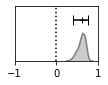

sigma_samples.shape: (5949, 3, 3)
rho_samples.shape: (5449, 3, 3)
CI_left 0.61, CI_right 0.85, mode 0.78
Save figure to:  D:/Brain_Network/Output/fig/LM_P2_AL_P2_Z_V1_P2_conditional_corr_embedded.pdf


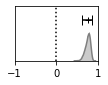

In [682]:
file_path = project_dir + 'Output/fig/V1_P2_AL_P2_Z_LM_P2_conditional_corr_embedded.pdf'
partial_index = [2,8, 5]
model.samples.plot_conditional_correlation_embedded(partial_index, burn_in=200, end=None, step=1, file_path=file_path)

file_path = project_dir + 'Output/fig/V1_P2_LM_P2_Z_AL_P2_conditional_corr_embedded.pdf'
partial_index = [2,5, 8]
model.samples.plot_conditional_correlation_embedded(partial_index, burn_in=500, end=None, step=1, file_path=file_path)

file_path = project_dir + 'Output/fig/LM_P2_AL_P2_Z_V1_P2_conditional_corr_embedded.pdf'
partial_index = [5,8, 2]
model.samples.plot_conditional_correlation_embedded(partial_index, burn_in=500, end=None, step=1, file_path=file_path)

### $z$ membership, clustering

(5980, 13, 261)


D:/Brain_Network/Code\samples.py:2928: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_column, c+1)
D:/Brain_Network/Code\samples.py:2928: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_column, c+1)
D:/Brain_Network/Code\samples.py:2928: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_column, c+1)
D:/Brain_Network/Code\samples.py:2928: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(num_rows, num_column, c+1)
D:/Brain_Network/Code\samples.py:292

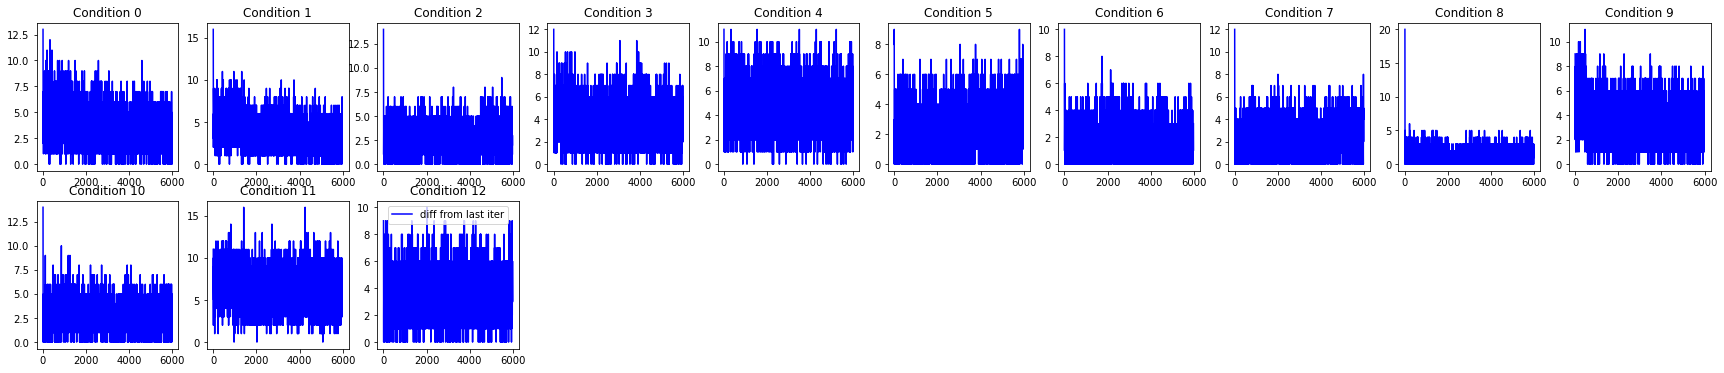

In [662]:
model.samples.plot_z_changes(burn_in=0, end=None, step=1)

z_samples.shape (5969, 13, 261)
z_samples.shape (13, 261, 5969)
save figure: D:/Brain_Network/Output/fig/798911424_z.pdf


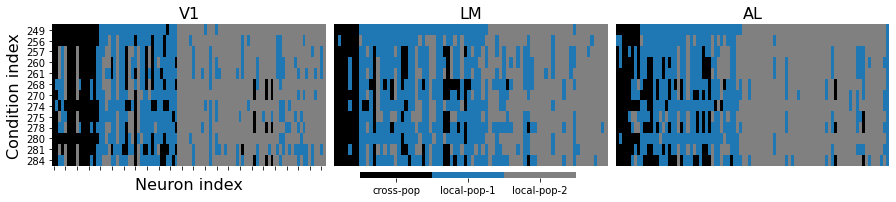

save figure: D:/Brain_Network/Output/fig/798911424_z_portion.pdf


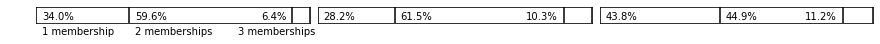

In [664]:
clist = list(range(len(condition_ids)))
output_dir = f'D:/Brain_Network/Output/fig/'
model.samples.plot_z(clist=clist, burn_in=10, end=-1, step=1, sub_group_df_c=model.sub_group_df_c,
                     condition_ids=all_condition_ids, output_dir=output_dir)

# Q-drifting virtual case test.

#### Generate samples.

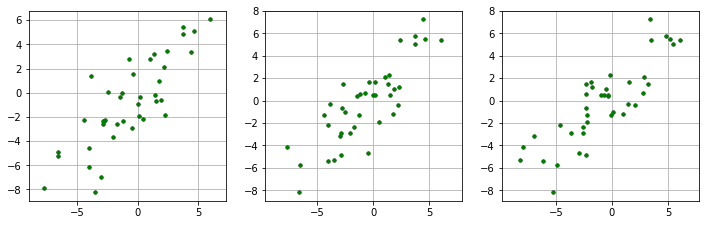

In [213]:
np.random.seed(0)
n = 40
sigma = np.array([[10, 8, 8], [8, 10, 8], [8, 8, 10]])
err_sigma = np.eye(3)*4
q_true = np.random.multivariate_normal(np.zeros(3), sigma, size=n)
q_obs = q_true  # + np.random.randn(n, 3)*2

plt.figure(figsize=[12, 3.5])
plt.subplot(131)
plt.plot(q_true[:,0], q_true[:,1], 'k.'); plt.plot(q_obs[:,0], q_obs[:,1], 'g.')
plt.axis('equal'); plt.grid()
plt.subplot(132)
plt.plot(q_true[:,0], q_true[:,2], 'k.'); plt.plot(q_obs[:,0], q_obs[:,2], 'g.')
plt.axis('equal'); plt.grid()
plt.subplot(133)
plt.plot(q_true[:,1], q_true[:,2], 'k.'); plt.plot(q_obs[:,1], q_obs[:,2], 'g.')
plt.axis('equal'); plt.grid()


In [219]:
q_samples = []
f_samples = []
q = q_true.copy() #   np.zeros_like(q_true)
f = np.zeros(3)
q_mean = np.zeros(3)
accept_cnt = 0
n_samples = 2000
proposal_cov = 0.2 * sigma

q_samples.append(q.copy())
for itr in tqdm(range(n_samples), ncols=100, file=sys.stdout):
    for r in range(n):
        q_prev = q[r]
        q_cnd = np.random.multivariate_normal(q_prev, proposal_cov)
        q_cnd -= 0*q_mean
        shrinker = 0*q_mean
        ll_cnd = scipy.stats.multivariate_normal.logpdf(q_cnd+f, q_obs[r], err_sigma)
        ll_prev = scipy.stats.multivariate_normal.logpdf(q_prev+f, q_obs[r], err_sigma)
        ll_cnd += scipy.stats.multivariate_normal.logpdf(q_prev, mean=q_cnd-shrinker, cov=proposal_cov)
        ll_prev += scipy.stats.multivariate_normal.logpdf(q_cnd, mean=q_prev-shrinker, cov=proposal_cov)

        mh_ratio = np.exp(ll_cnd - ll_prev)
        u = np.random.rand()
        if u < mh_ratio:
            accept_cnt += 1
            q[r] = q_cnd
        if r == n-1:
            q_samples.append(q.copy())

    q_mean = np.mean(q, axis=0)
    f = np.mean(q, axis=0)
    f_samples.append(f.copy())


100%|███████████████████████████████████████████████████████████| 2000/2000 [00:48<00:00, 41.52it/s]


accept ratio:0.6168625
[-0.702367   -0.82721772 -0.22682004] [-0.34664973 -0.43381627 -0.11136703]
1.9489058651001117
r3	STD [2.06753709 1.82106198 2.00701242]
r9	STD [1.97436306 2.08512029 1.98759975]


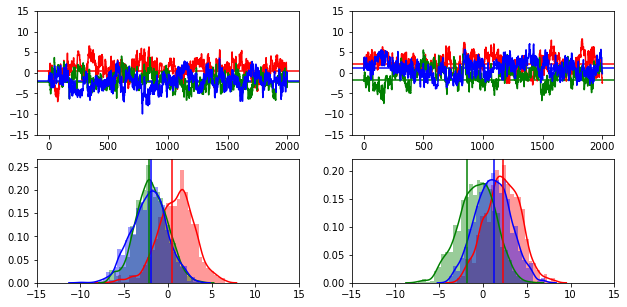

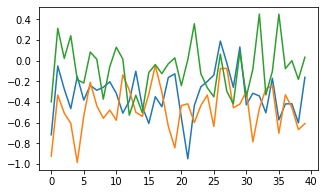

In [222]:
qs = np.stack(q_samples, axis=0)
fs = np.stack(f_samples, axis=0)
print(f'accept ratio:{accept_cnt/n/n_samples}')
print(q_obs.mean(axis=0), qs.mean(axis=(0,1)))
print(np.std(qs, axis=0).mean())

lim = 15
r = 3 # 11
print(f'r{r}\tSTD', np.std(qs[:,r,:], axis=0))
plt.figure(figsize=[16,5])
plt.subplot(231)
plt.axhline(q_obs[r,0],c='r'); plt.axhline(q_obs[r,1],c='g'); plt.axhline(q_obs[r,2],c='b')
plt.plot(qs[:,r,0],c='r');plt.plot(qs[:,r,1],c='g');plt.plot(qs[:,r,2],c='b')
plt.ylim(-lim, lim)
plt.subplot(234)
seaborn.distplot(qs[:,r,0],color='r'); seaborn.distplot(qs[:,r,1],color='g'); seaborn.distplot(qs[:,r,2],color='b'); 
plt.axvline(q_obs[r,0],c='r'); plt.axvline(q_obs[r,1],c='g'); plt.axvline(q_obs[r,2],c='b')
plt.xlim(-lim, lim)

r = 9
print(f'r{r}\tSTD', np.std(qs[:,r,:], axis=0))
plt.subplot(232)
plt.axhline(q_obs[r,0],c='r'); plt.axhline(q_obs[r,1],c='g'); plt.axhline(q_obs[r,2],c='b')
plt.plot(qs[:,r,0],c='r');plt.plot(qs[:,r,1],c='g');plt.plot(qs[:,r,2],c='b')
plt.ylim(-lim, lim); 
plt.subplot(235)
seaborn.distplot(qs[:,r,0],color='r'); seaborn.distplot(qs[:,r,1],color='g'); seaborn.distplot(qs[:,r,2],color='b'); 
plt.axvline(q_obs[r,0],c='r'); plt.axvline(q_obs[r,1],c='g'); plt.axvline(q_obs[r,2],c='b')
plt.xlim(-lim, lim)
plt.show()

plt.figure(figsize=[5,3])
plt.subplot(111)
plt.plot(fs[::50])
plt.show()

accept ratio:0.403725
r3	STD [1.81568429 2.19694907 2.141711  ]
r9	STD [1.86613024 1.68393578 1.91528911]


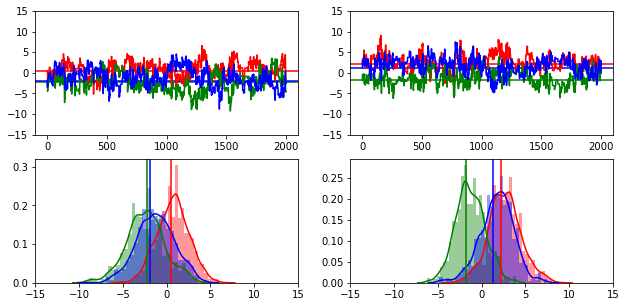

[-0.702367   -0.82721772 -0.22682004] [-0.39976187 -0.49469121 -0.03049729]
1.9087899486332132


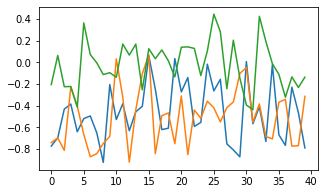